In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))

setwd("~/Repositories/AirQualityCOVID/")

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=15,
        repr.plot.height=15,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
variable <- "no2"
html.variable <- c("no" = "NO",
                   "no2" = "NO<sub>2</sub>",
                   "o3" = "O<sub>3</sub>",
                   "pm10" = "PM10",
                   "pm2.5" = "PM2.5"
                  )
method <- "lm"

In [4]:
load(paste("data/Analysis/predictions-",
           method,"-", variable,".rda", sep=""))

sites.lv <- read.csv("data/Curation/checked_AQ.csv") %>%
            filter(Pollutant == variable) 

In [5]:
results$diff <- (results$obs - results$pred.qq) / results$pred.qq

spain.results <- results %>%
                select(date, diff) %>%
                group_by(date) %>% 
                summarise(diff = mean(diff, na.rm=T)) %>%
                openair::timeAverage(avg.time = "day")

spain.results$date <- lubridate::as_date(spain.results$date)

# Lockdown dates

In [6]:
periods <- list(
    # Prelockdown
    pre.lockdown = lubridate::ymd("2020-01-01"),

    # lockdown
    lockdown = lubridate::ymd("2020-03-14"),
    #end.lockdown = ymd_hms("2020-04-28 00:00:00"),

    # poslockdown
    fases = lubridate::ymd("2020-05-01"),
    normalidad = lubridate::ymd("2020-06-21"),

    # New lockdown
    new.lockdown = lubridate::ymd("2020-10-25"),
    end.year = lubridate::ymd("2020-12-31")
)

## Breakpoints

## Using `segmented` package

In [7]:
suppressMessages(library(segmented))
suppressMessages(library(plyr))

In [8]:
seg.df <- segmented(lm(diff ~ date + 1, 
                       data=spain.results), 
                    seg.Z = ~date,
                    psi = unlist(periods[2:5])
                   )

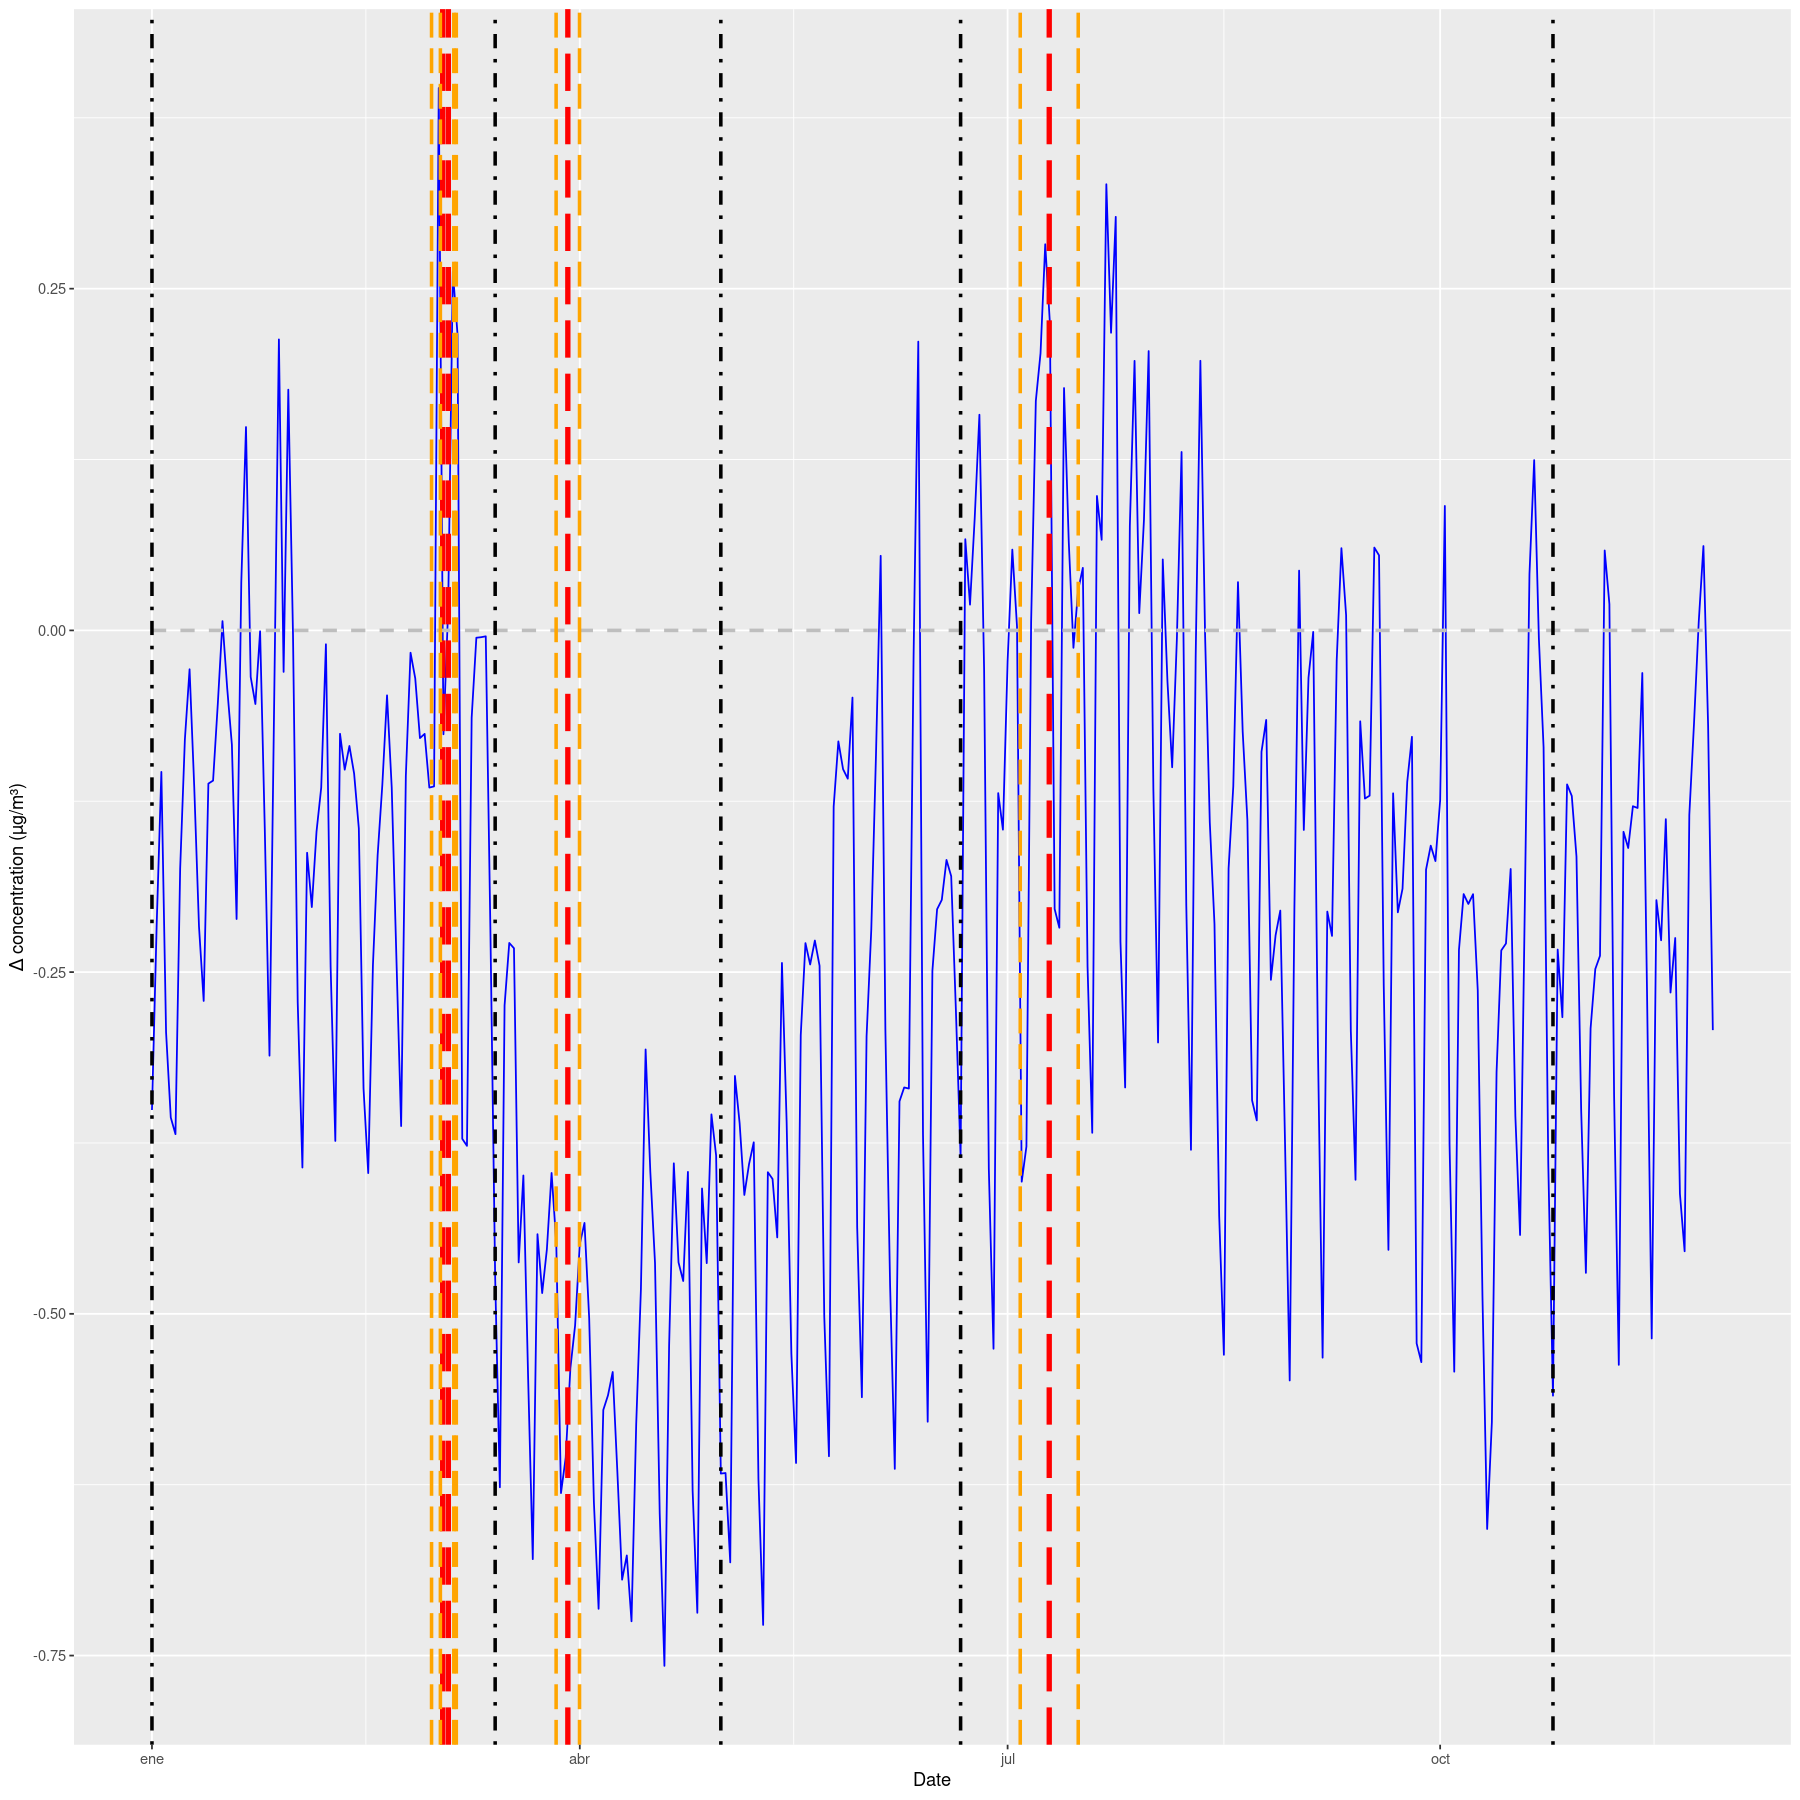

In [9]:
plot <- ggplot(data=spain.results,aes(x=lubridate::as_date(date)))+ 
    geom_line(aes(y=diff), color="blue", size=0.5) +
    geom_line(aes(y=0), color="gray", linetype=2, size=1) +
    xlab("Date") + ylab("\u0394 concentration (\u00b5g/m\u00b3)")

plot <- plot +
    geom_vline(data=data.frame(seg.df$psi), aes(xintercept = Est.), 
               linetype=5, color = "red", size=1.5) +
    geom_vline(data=data.frame(seg.df$psi), aes(xintercept = Est.+St.Err), 
               linetype=5, color = "orange", size=1) +
    geom_vline(data=data.frame(seg.df$psi), aes(xintercept = Est.-St.Err), 
               linetype=5, color = "orange", size=1)

for (k in 1:(length(periods))) {
    plot <- plot + geom_vline(xintercept = as.numeric(periods[k]), 
                              linetype=4, color = "black", size=1)
}

plot

In [10]:
change <- list(serie = data.frame(),
               speed = data.frame())

for (i in 1:nrow(seg.df$psi)) {
        dat <- spain.results %>% 
                filter(date >= seg.df$psi[i-1, "Est."],
                       date <= seg.df$psi[i, "Est."],
                       diff < Inf
                      )
        if (nrow(dat) == 0) {next()}
        
        dat.model <- lm(diff ~ date, data = dat, na.action = na.omit)
        
        change[["speed"]] <- rbind(change[["speed"]],
                              data.frame(period = names(periods)[i-1],
                                         speed = dat.model$coefficients[2]
                                  ))
        change[["serie"]] <- rbind(change[["serie"]],
                              data.frame(period = names(periods)[i-1],
                                         date = dat$date,
                                         diff = dat$diff,
                                         fit = predict(dat.model))
                             )
    }

ERROR: Error: Problem with `filter()` input `..1`.
[31m✖[39m Input `..1` must be of size 333 or 1, not size 0.
[34mℹ[39m Input `..1` is `date >= seg.df$psi[i - 1, "Est."]`.


In [ ]:
ggplot(change[["serie"]]) +
    geom_line(aes(x=date, y=diff, color=period)) +
    geom_line(aes(x=date, y=fit, color=period))